In [ ]:
!pip install torch==1.7.1 torchaudio==0.7.2

     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 7.6 MB 20.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0+cu113
    Uninstalling torchaudio-0.11.0+cu113:
      Successfully uninstalled torchaudio-0.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
import os
from scipy.io import wavfile
import librosa
import numpy as np

In [ ]:
from IPython import display
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio

assert torch.__version__.startswith('1.7.1')
assert torchaudio.__version__ == '0.7.2'

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
!wget https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py

--2022-05-05 09:37:10--  https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3422 (3.3K) [text/plain]
Saving to: ‘gfile.py’

gfile.py            100%[===================>]   3.34K  --.-KB/s    in 0s      

2022-05-05 09:37:10 (32.3 MB/s) - ‘gfile.py’ saved [3422/3422]



In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!mkdir data
# датасет тут: https://drive.google.com/file/d/1twV3zAmGEziFS5Jynt8JTsyIqKGxebjj/view?usp=sharing 

!cp '/content/drive/MyDrive/numbers.zip' numbers.zip

!unzip numbers.zip -d data/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/numbers/train/801651b0f6.wav  
  inflating: data/numbers/train/ede78d6a0a.wav  
  inflating: data/numbers/train/a843ab4929.wav  
  inflating: data/numbers/train/2acd9902a2.wav  
  inflating: data/numbers/train/057af5ead7.wav  
  inflating: data/numbers/train/f8e00659fc.wav  
  inflating: data/numbers/train/b46faf7d70.wav  
  inflating: data/numbers/train/591dceff39.wav  
  inflating: data/numbers/train/2b1716688e.wav  
  inflating: data/numbers/train/6093d3673f.wav  
  inflating: data/numbers/train/309528b196.wav  
  inflating: data/numbers/train/bc056ce093.wav  
  inflating: data/numbers/train/7e9e79ece9.wav  
  inflating: data/numbers/train/22e33c6bef.wav  
  inflating: data/numbers/train/90c3173913.wav  
  inflating: data/numbers/train/e1c73df0c5.wav  
  inflating: data/numbers/train/2914431f40.wav  
  inflating: data/numbers/train/460a17e170.wav  
  inflating: data/numbers/train/fd5b2030a6.wav  
 

In [ ]:
import os

import pandas as pd
import numpy as np


class SpeechDataset(Dataset):
    
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = 'data/numbers'

    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))
        return torch.LongTensor(digits)

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]
        
        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            path, = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)
        
        wav = wav.squeeze()

        instance = {
            'path': path,
            'x': wav,
            'y': y
        }

        return instance

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
dataset = SpeechDataset('data/numbers/train.csv')

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

random_indexes = torch.randperm(len(dataset)).tolist()
train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [ ]:
len(train_dataset), len(val_dataset)

(8100, 900)

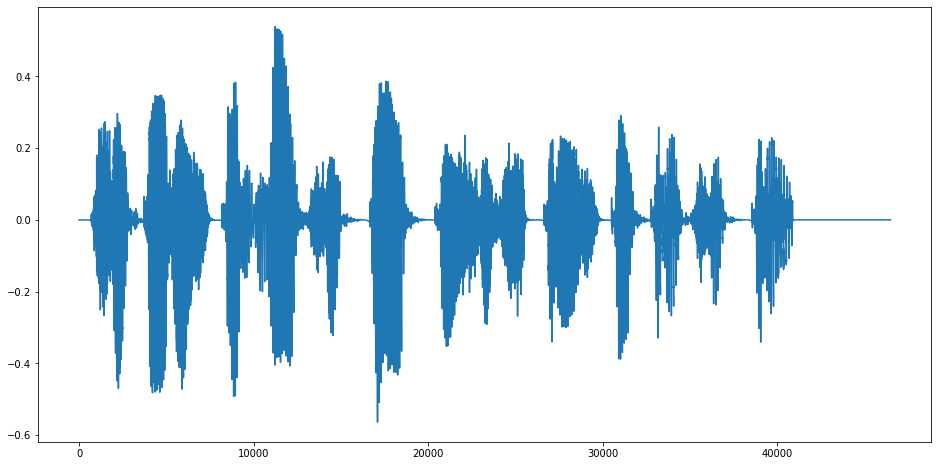

In [ ]:
instance = train_dataset[0]
plt.figure(figsize=(16, 8))
plt.plot(instance['x'])

display.Audio(instance['x'], rate=dataset.SAMPLE_RATE)

In [ ]:
instance['y']

tensor([4, 2, 5, 3, 3, 3])

In [ ]:
from tqdm import tqdm
from itertools import islice


class PaddingCollator:

    def __call__(self, instances):
        batch_size = len(instances)
        x_len = torch.LongTensor([instance['x'].size(0) for instance in instances])
        y_len = torch.LongTensor([instance['y'].size(0) for instance in instances])
        path = [instance['path'] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- паддинг

        for i, instance in enumerate(instances):
            x[i, :x_len[i]] = instance['x']
            y[i, :y_len[i]] = instance['y']

        instance = {
            'x': x,
            'y': y,
            'x_len': x_len,
            'y_len': y_len,
            'path': path
        }
        
        return instance

In [ ]:
train_dataloader = DataLoader(train_dataset, 64,
                              collate_fn=PaddingCollator(), shuffle=True,
                              pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32, collate_fn=PaddingCollator(),
                            pin_memory=True)

In [ ]:
batch = list(islice(val_dataloader, 1))[0]
batch

{'path': ['data/numbers/train/e434989a2d.wav',
  'data/numbers/train/a49bf1048a.wav',
  'data/numbers/train/31b4e385f9.wav',
  'data/numbers/train/95b3ce4645.wav',
  'data/numbers/train/49a0eae446.wav',
  'data/numbers/train/849525bdd1.wav',
  'data/numbers/train/3de0c567f1.wav',
  'data/numbers/train/c8827c1f59.wav',
  'data/numbers/train/ef9f8b5886.wav',
  'data/numbers/train/1494a42cc5.wav',
  'data/numbers/train/9cece87a14.wav',
  'data/numbers/train/21327151e6.wav',
  'data/numbers/train/dfed44cf47.wav',
  'data/numbers/train/8f9c7efb66.wav',
  'data/numbers/train/83b5622f53.wav',
  'data/numbers/train/149d6e1141.wav',
  'data/numbers/train/83cc84bee2.wav',
  'data/numbers/train/9d893af33a.wav',
  'data/numbers/train/b12e7fe8e2.wav',
  'data/numbers/train/65442f4270.wav',
  'data/numbers/train/f3d1022676.wav',
  'data/numbers/train/95b6da9dbe.wav',
  'data/numbers/train/268e56b5ec.wav',
  'data/numbers/train/3abd3b4fb6.wav',
  'data/numbers/train/33994064bc.wav',
  'data/numbers/t

In [ ]:
instance = train_dataset[31]
wav = instance['x']

In [ ]:
from torchaudio.transforms import MelSpectrogram

In [ ]:
featurizer = MelSpectrogram(
    sample_rate=train_dataset.dataset.SAMPLE_RATE,
    n_fft=512,
    win_length=512,
    hop_length=512,
    n_mels=64,
    power=1
)

def apply_compression(melspec):
    # eps=1e-7 чтобы избежать log(0)
    return torch.log(melspec.clamp(1e-5))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


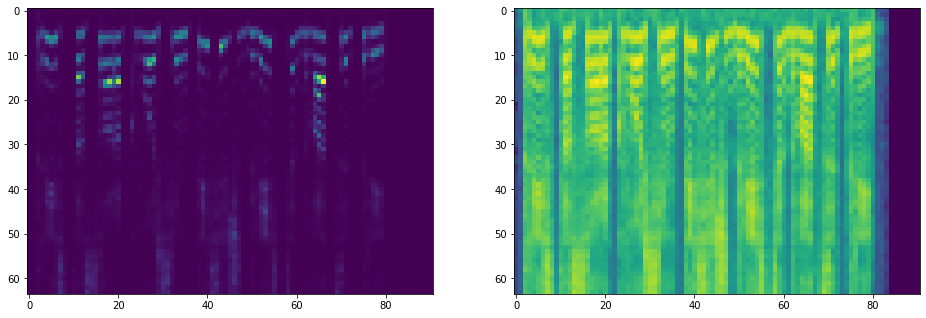

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(featurizer(wav))
axes[1].imshow(apply_compression(featurizer(wav)))

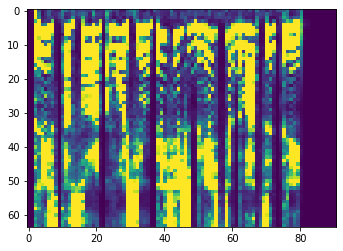

In [ ]:
# Аугментация Мел-спектрограммы
effects = [
    ['gain', '-n'],  # normalises to 0dB
    ['pitch', '5'],  # 5 cent pitch shift
    ]
waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
                                            featurizer(wav).cpu(),
                                            16000, effects, channels_first=True)
plt.imshow(waveform)

In [ ]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            power=1
        )
    
    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)

        
        # Переводим длинну из wav размера в melSpec размер
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len
        
        return x

## Модель

In [ ]:
from torch import nn


class MainBlock(nn.Module):
    
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 10,
    ):
        super().__init__()
        
        self.repeat = repeat
        self.blocks = nn.ModuleList([
            nn.ModuleList([
                nn.Conv1d(
                    in_channels=in_channels if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    groups=in_channels if i == 0 else hidden_channels,
                    padding=kernel_size // 2
                ),
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
            ])
            for i in range(repeat)
        ])
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x):
        x_initial = x
        
        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j ==( len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x



In [ ]:
class MyModel(nn.Module):

    
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.prenet = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 33, padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )
        
        self.net = nn.Sequential(
            MainBlock(hidden_channels, hidden_channels),
            MainBlock(hidden_channels, hidden_channels * 2),

            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, 33,
                      padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),

            MainBlock(hidden_channels * 2, hidden_channels * 4)
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x, x_len):
        x = self.prenet(x)
        x = self.net(x)
        return self.classifier(x), x_len // 4

# MyModel(64, 128, 10 + 1)

In [ ]:
!pip install Levenshtein

     |████████████████████████████████| 258 kB 12.5 MB/s 
     |████████████████████████████████| 1.8 MB 48.6 MB/s 
     |████████████████████████████████| 103 kB 47.5 MB/s 


In [ ]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = ''.join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    
    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(
            target + '\t\t' + decoding
        )

    return cer / len(target), pairs

## Обучение

In [ ]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda:0')

model = MyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:


from IPython import display
from collections import defaultdict

In [ ]:
history = defaultdict(list)

In [ ]:
import random


In [ ]:
effects = [
            ['gain', '-n'],  # normalises to 0dB
            ['pitch', '5'],  # 5 cent pitch shift
          ]

In [ ]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.clone()
    for i in range(num_mask):
        all_freqs_num, all_frames_num, t = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

Epoch: 19
Example of prediction:  110036 -> 110036
Example of prediction:  984738 -> 984738
Example of prediction:  490905 -> 490905
Example of prediction:  831394 -> 831394
Example of prediction:  160811 -> 160811


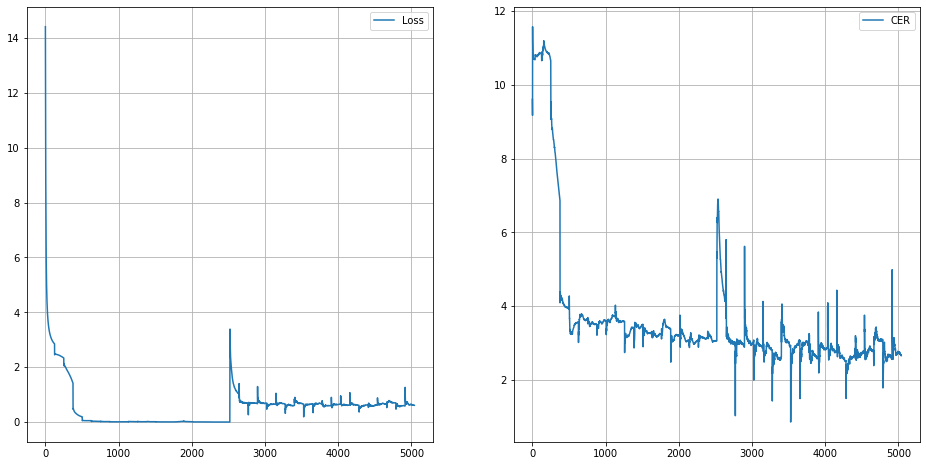

In [ ]:
for epoch in range(NUM_EPOCH):

    average_cer = AverageMeter()
    average_loss = AverageMeter()
    
    for batch in train_dataloader:
        x = batch['x'].to(DEVICE)
        y = batch['y'].to(DEVICE)
        x_len = batch['x_len'].to(DEVICE)
        y_len = batch['y_len'].to(DEVICE)
        
        x, x_len = mel_featurizer(x, x_len)
        x = spec_augment(x)

        log_probs, x_len = model(x, x_len)
        
        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu() \
            .argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history['loss'].append(average_loss.avg)
        history['cer'].append(average_cer.avg)
    
    display.clear_output()
    print(f'Epoch: {epoch}')
    for i in range(5):
        print(f'Example of prediction: ', pairs[i].replace("\t\t", " -> "))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    plt.show()

    print(average_cer)
    print(average_loss)